In [1]:

def water(index, data, Title="", x_lab="", y_lab="",
              formatting = "{:,.1f}", green_color='#29EA38', red_color='#FB3C62', blue_color='#24CAFF',
             sorted_value = False, threshold=None, other_label='other', net_label='net', 
             rotation_value = 30, blank_color=(0,0,0,0), figsize = (10.871,5.515)):
    '''
    Given two sequences ordered appropriately, generate a standard waterfall chart.
    Optionally modify the title, axis labels, number formatting, bar colors, 
    increment sorting, and thresholding. Thresholding groups lower magnitude changes
    into a combined group to display as a single entity on the chart.
    '''
    
    #convert data and index to np.array
    index=np.array(index)
    data=np.array(data)
    
    # wip
    #sorted by absolute value 
    if sorted_value: 
        abs_data = abs(data)
        data_order = np.argsort(abs_data)[::-1]
        data = data[data_order]
        index = index[data_order]
    
    #group contributors less than the threshold into 'other' 
    if threshold:
        
        abs_data = abs(data)
        threshold_v = abs_data.max()*threshold
        
        if threshold_v > abs_data.min():
            index = np.append(index[abs_data>=threshold_v],other_label)
            data = np.append(data[abs_data>=threshold_v],sum(data[abs_data<threshold_v]))
    
    changes = {'amount' : data}
    
    #define format formatter
    def money(x, pos):
        'The two args are the value and tick position'
        return formatting.format(x)
    formatter = FuncFormatter(money)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.yaxis.set_major_formatter(formatter)

    #Store data and create a blank series to use for the waterfall
    trans = pd.DataFrame(data=changes,index=index)
    blank = trans.amount.cumsum().shift(1).fillna(0)
    
    trans['positive'] = trans['amount'] > 0

    #Get the net total number for the final element in the waterfall
    total = trans.sum().amount
    trans.loc[net_label]= total
    blank.loc[net_label] = total

    #The steps graphically show the levels as well as used for label placement
    step = blank.reset_index(drop=True).repeat(3).shift(-1)
    step[1::3] = np.nan

    #When plotting the last element, we want to show the full bar,
    #Set the blank to 0
    blank.loc[net_label] = 0
    
    #define bar colors for net bar
    trans.loc[trans['positive'] > 1, 'positive'] = 99
    trans.loc[trans['positive'] < 0, 'positive'] = 99
    trans.loc[(trans['positive'] > 0) & (trans['positive'] < 1), 'positive'] = 99
    
    trans['color'] = trans['positive']
    
    trans.loc[trans['positive'] == 1, 'color'] = green_color
    trans.loc[trans['positive'] == 0, 'color'] = red_color
    trans.loc[trans['positive'] == 99, 'color'] = blue_color
    
    my_colors = list(trans.color)
    
    #Plot and label
    my_plot = plt.bar(range(0,len(trans.index)), blank, width=0.5, color=blank_color)
    plt.bar(range(0,len(trans.index)), trans.amount, width=0.6,
             bottom=blank, color=my_colors)       
                                   
    
    # connecting lines - figure out later
    #my_plot = lines.Line2D(step.index, step.values, color = "gray")
    #my_plot = lines.Line2D((3,3), (4,4))
    
    #axis labels
    plt.xlabel("\n" + x_lab)
    plt.ylabel(y_lab + "\n")

    #Get the y-axis position for the labels
    y_height = trans.amount.cumsum().shift(1).fillna(0)
    
    temp = list(trans.amount)
    
    # create dynamic chart range
    for i in range(len(temp)):
        if (i > 0) & (i < (len(temp) - 1)):
            temp[i] = temp[i] + temp[i-1]
    
    trans['temp'] = temp
            
    plot_max = trans['temp'].max()
    plot_min = trans['temp'].min()
    
    #Make sure the plot doesn't accidentally focus only on the changes in the data
    if all(i >= 0 for i in temp):
        plot_min = 0
    if all(i < 0 for i in temp):
        plot_max = 0
    
    if abs(plot_max) >= abs(plot_min):
        maxmax = abs(plot_max)   
    else:
        maxmax = abs(plot_min)
        
    pos_offset = maxmax / 40
    
    plot_offset = maxmax / 15 ## needs to me cumulative sum dynamic

    #Start label loop
    loop = 0
    for index, row in trans.iterrows():
        # For the last item in the list, we don't want to double count
        if row['amount'] == total:
            y = y_height[loop]
        else:
            y = y_height[loop] + row['amount']
        # Determine if we want a neg or pos offset
        if row['amount'] > 0:
            y += (pos_offset*2)
            plt.annotate(formatting.format(row['amount']),(loop,y),ha="center", color = 'k', fontsize=12)
        else:
            y -= (pos_offset*4)
            plt.annotate(formatting.format(row['amount']),(loop,y),ha="center", color = 'k', fontsize=12)
        loop+=1

    #Scale up the y axis so there is room for the labels
    plt.ylim(plot_min-round(3.6*plot_offset, 7),plot_max+round(3.6*plot_offset, 7))
    
    #Rotate the labels
    plt.xticks(range(0,len(trans)), trans.index, rotation=rotation_value)
    
    #add zero line and title
    plt.axhline(0, color='black', linewidth = 0.6, linestyle="dashed")
    plt.title(Title)
    plt.tight_layout()

    return fig, ax

In [2]:
# from IPython.display import Markdown, display

# display(Markdown("000_independencia_energetica.md"))
# https://www.kaggle.com/code/imdevskp/geopandas/notebook

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser  import parse
import waterfall_chart
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

import geopandas as gpd

import matplotlib as mpl

mpl.rcParams.keys()
mpl.rcParams['lines.linewidth']         = 2
mpl.rcParams['lines.markersize']        = 10
mpl.rcParams['lines.markerfacecolor']   = "white"
mpl.rcParams['font.family']             = 'sans-serif'
mpl.rcParams['font.sans-serif']         = "Tahoma"
mpl.rcParams['font.size']               = 18

# colores
azulier        = "#1A3D6F"
naranjaier     = '#C65C25'
amarilloclaro  = '#f6ec7f'
naranja        = '#d8a700'
tamanio  = (10.871,5.515)
mpl.rcParams["figure.figsize"] = tamanio

# mpl.rcParams['lines.linestyle'] = '--'
# mpl.rcParams['lines.linestyle'] = '--'

In [4]:
# pip install geopandas

In [5]:
f = 'PlantasSolares.xlsx'
f = 'PlantasSolares02.xlsx'  
ps = pd.read_excel(f,skiprows=[0,1],skipfooter=4,index_col=[5])
ps.sort_index(inplace=True)
ps.columns
ps

,Unnamed: 0,Empresa,Estado,Lat,Lon,Unnamed: 6,Nombre del colector,Tipo de colector,"Area instalada (gross), m2","Área instalada (apertura), m2","Installed thermal power , kWth",Solar collector loop heat transfer fluid,Solar energy storage,"Storage volume, m³",Kind of conventional heat source,Kind of fuel used
Inicio de operación,,,,,,,,,,,,,,,,
2012,25,Lacto Productos El Indio,"San José de Gracia, Michoacán",NaN,NaN,other process heating,Power Trough 110,parabolic trough collector,401.10,132,74.00,water,short-term water storage,5,steam boiler,fuel oil
2013,33,Matatlan Dairy,"Matatlán, Zapotlanejo, Jalisco.",NaN,NaN,general processing heating,Power Trough 110,parabolic trough collector,66.00,NaN,46.20,water,short-term water storage,2.5,steam boiler,other
2013,34,Buenavista Greenhouse,"Buenavista, Jalisco, México",NaN,NaN,heating of producction halls,Power Trough 110,parabolic trough collector,112.00,66,36.00,water,short-term water storage,2.5,hot water boiler,natural gas
2013,3,Durango Dairy Company (Productos Lácteos COVBARS),"Av. Francisco Villa 1211, Villa de Guadalupe, ...",24.033543,-104.686407,Pasteurización,Power Trough 110,parabolic trough collector,265.68,132,46.20,water,short-term water storage,7,steam boiler,fuel oil
2014,32,Biotecnología Mexicana de Microalgas S.A. de C.V.,"Zapopan, Jalisco, Mexico",NaN,NaN,general processing heating,Power Trough 110,parabolic trough collector,110.00,66,31.67,water,short-term water storage,10,NaN,NaN
2014,8,Quesos La Doñita,"Neutla, Guanajuato, Mexico",NaN,NaN,Pasteurización,Power Trough 110,parabolic trough collector,66.00,39.6,22.20,water,short-term water storage,1.5,hot water boiler,natural gas
2014,18,Nutrición Marina,Carretera Federal Libre Los Mochis - San Migue...,NaN,NaN,Cooking,Power Trough 110,parabolic trough collector,310.00,178.2,97.20,water,short-term water storage,7.5,steam boiler,fuel oil
2014,6,NESTLE DAIRY PLANT LAGOS DE MORENO,"Lagos de Moreno, Jalisco",21.368154,-101.922474,Pasteurización,Power Trough 110,parabolic trough collector,1327.59,462,137.00,water,short-term water storage,5,steam boiler,natural gas
2014,5,NESTLE DAIRY PLANT CHAPA DE CORZO,"Chiapa de Corzo, México\t\n",16.706989,-93.002907,Pasteurización,Power Trough 110,parabolic trough collector,460.00,224.5,126.00,water,short-term water storage,5,steam boiler,other


In [6]:
ps

,Unnamed: 0,Empresa,Estado,Lat,Lon,Unnamed: 6,Nombre del colector,Tipo de colector,"Area instalada (gross), m2","Área instalada (apertura), m2","Installed thermal power , kWth",Solar collector loop heat transfer fluid,Solar energy storage,"Storage volume, m³",Kind of conventional heat source,Kind of fuel used
Inicio de operación,,,,,,,,,,,,,,,,
2012,25,Lacto Productos El Indio,"San José de Gracia, Michoacán",NaN,NaN,other process heating,Power Trough 110,parabolic trough collector,401.10,132,74.00,water,short-term water storage,5,steam boiler,fuel oil
2013,33,Matatlan Dairy,"Matatlán, Zapotlanejo, Jalisco.",NaN,NaN,general processing heating,Power Trough 110,parabolic trough collector,66.00,NaN,46.20,water,short-term water storage,2.5,steam boiler,other
2013,34,Buenavista Greenhouse,"Buenavista, Jalisco, México",NaN,NaN,heating of producction halls,Power Trough 110,parabolic trough collector,112.00,66,36.00,water,short-term water storage,2.5,hot water boiler,natural gas
2013,3,Durango Dairy Company (Productos Lácteos COVBARS),"Av. Francisco Villa 1211, Villa de Guadalupe, ...",24.033543,-104.686407,Pasteurización,Power Trough 110,parabolic trough collector,265.68,132,46.20,water,short-term water storage,7,steam boiler,fuel oil
2014,32,Biotecnología Mexicana de Microalgas S.A. de C.V.,"Zapopan, Jalisco, Mexico",NaN,NaN,general processing heating,Power Trough 110,parabolic trough collector,110.00,66,31.67,water,short-term water storage,10,NaN,NaN
2014,8,Quesos La Doñita,"Neutla, Guanajuato, Mexico",NaN,NaN,Pasteurización,Power Trough 110,parabolic trough collector,66.00,39.6,22.20,water,short-term water storage,1.5,hot water boiler,natural gas
2014,18,Nutrición Marina,Carretera Federal Libre Los Mochis - San Migue...,NaN,NaN,Cooking,Power Trough 110,parabolic trough collector,310.00,178.2,97.20,water,short-term water storage,7.5,steam boiler,fuel oil
2014,6,NESTLE DAIRY PLANT LAGOS DE MORENO,"Lagos de Moreno, Jalisco",21.368154,-101.922474,Pasteurización,Power Trough 110,parabolic trough collector,1327.59,462,137.00,water,short-term water storage,5,steam boiler,natural gas
2014,5,NESTLE DAIRY PLANT CHAPA DE CORZO,"Chiapa de Corzo, México\t\n",16.706989,-93.002907,Pasteurización,Power Trough 110,parabolic trough collector,460.00,224.5,126.00,water,short-term water storage,5,steam boiler,other


In [7]:
ps['Installed thermal power , kWth']

Inicio de operación
2012     74.00
2013     46.20
2013     36.00
2013     46.20
2014     31.67
2014     22.20
2014     97.20
2014    137.00
2014    126.00
2014     62.72
2015    240.00
2015     22.20
2015     94.50
2015     94.60
2015     43.38
2015    118.00
2015    116.02
2015    126.30
2015     42.00
2016     59.88
2016     27.11
2017    179.85
2017     35.34
2017     15.05
2017    202.54
2017    112.85
2017     92.61
2017     64.83
2017    104.81
2017     77.90
2017    136.79
2017    123.55
2017     59.90
2018    110.88
2018    177.80
2019    266.00
Name: Installed thermal power , kWth, dtype: float64

In [8]:
ps['Installed thermal power , kWth'].groupby(by=[ps.index]).sum()

Inicio de operación
2012      74.00
2013     128.40
2014     476.79
2015     897.00
2016      86.99
2017    1206.02
2018     288.68
2019     266.00
Name: Installed thermal power , kWth, dtype: float64

In [9]:
ps['Installed thermal power , kWth'].groupby(by=[ps.index]).sum().cumsum()

Inicio de operación
2012      74.00
2013     202.40
2014     679.19
2015    1576.19
2016    1663.18
2017    2869.20
2018    3157.88
2019    3423.88
Name: Installed thermal power , kWth, dtype: float64

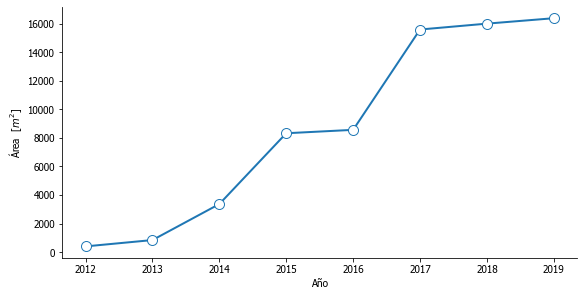

In [10]:
fig, ax = plt.subplots(constrained_layout=True,figsize=(8,4))


ax.plot(ps['Area instalada (gross), m2'].groupby(by=[ps.index]).sum().cumsum(), '-o',
        label="Area instalada")

ax.set_ylabel("Área  [$m^2$]")
ax.set_xlabel('Año')
ax.spines[['top','right']].set_visible(False)
plt.savefig('AreaInstalada.png')

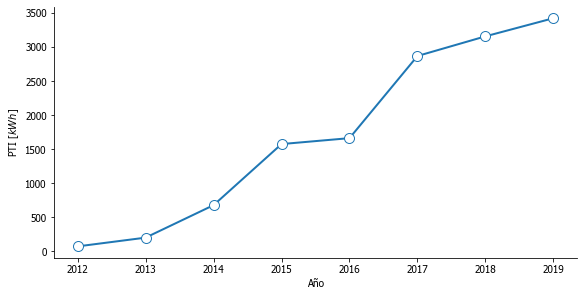

In [11]:
fig, ax = plt.subplots(constrained_layout=True,figsize=(8,4))


ax.plot(ps['Installed thermal power , kWth'].groupby(by=[ps.index]).sum().cumsum(), '-o',
        label="Area instalada")


ax.set_ylabel("PTI [$kWh$]")
ax.set_xlabel('Año')
ax.spines[['top','right']].set_visible(False)
plt.savefig('PotenciaTermicaInstalada.png')

<ipython-input-1-31300fb6cdb4>:58: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  step[1::3] = np.nan


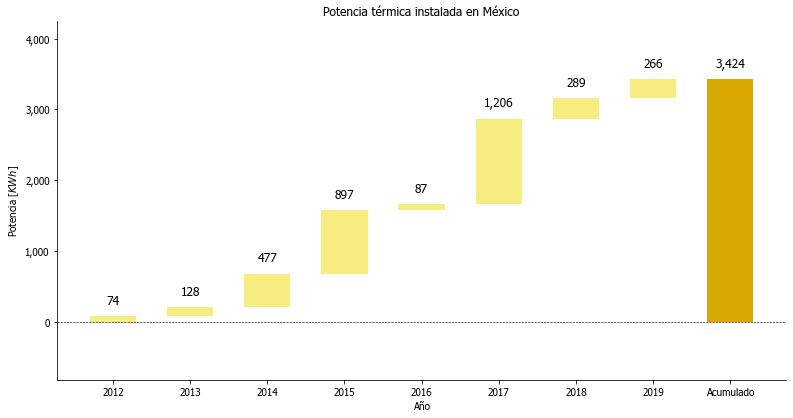

In [12]:
a = ps['Installed thermal power , kWth'].groupby(by=[ps.index]).sum().index.to_list()
a  = [str(A) for A in a]
b = ps['Installed thermal power , kWth'].groupby(by=[ps.index]).sum().to_list()

water(a, b, 
     rotation_value=0, 
     sorted_value=False,
     formatting="{:,.0f}",
     net_label='Acumulado',
     other_label='Peor año',
     blue_color=naranja, 
     green_color=amarilloclaro, 
     red_color='blue')
plt.title('Potencia térmica instalada en México')
plt.ylabel('Potencia [$KWh$]')
plt.xlabel('Año')
sns.despine()
# plt.show()


Text(141.91358532392266, 0.5, 'Latitude')

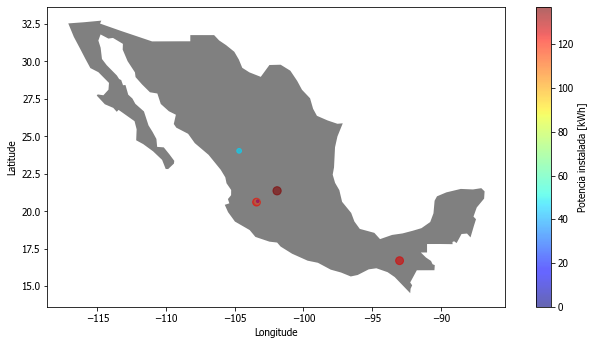

In [13]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
mex =worldmap.loc[worldmap.iso_a3=='MEX']

fig, ax = plt.subplots(figsize=tamanio)
mex =worldmap.loc[worldmap.iso_a3=='MEX']
mex.plot(color="grey", ax=ax)

# Plotting our Impact Energy data with a color map
x = ps.Lon
y = ps.Lat
z = ps['Installed thermal power , kWth']
mapa = ax.scatter(x, y, s=0.5*z, c=z, alpha=0.6, vmin=0,
            cmap='jet')
fig.colorbar(mapa,label='Potencia instalada [kWh]')

 
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

In [14]:
# plantas

In [15]:
mx   = gpd.read_file('mapa_mexico/').set_index('NOMEDO').to_crs(epsg=4485)
base = gpd.read_file('mapa_mexico/').set_index('NOMEDO').to_crs(epsg=4485)


f = 'https://docs.google.com/spreadsheets/d/' + '1000UCid4YLrPbrn5WmXpo08Eoi3D3ipLP_rThk-1Jko' + '/export?gid=0&format=csv'
plantas = pd.read_csv(f,skiprows=1,index_col='NOMEDO')
plantas = plantas[['Installed thermal power , kWth']].groupby(by='NOMEDO').sum()
mx = mx.join(plantas,how='left')
mx

,CLAVE,NOM_MUN,CVE_EDO,CVE_MUNI,Area,geometry,"Installed thermal power , kWth"
NOMEDO,,,,,,,
Aguascalientes,01004,Cosio,01,004,128.907513,"POLYGON ((1397788.297 2509816.078, 1398009.089...",42.0
Aguascalientes,01007,Rincon de Romos,01,007,372.937842,"POLYGON ((1403129.378 2500606.440, 1403493.353...",42.0
Aguascalientes,01009,Tepezal,01,009,228.886009,"POLYGON ((1409534.910 2499654.056, 1409720.076...",42.0
Aguascalientes,01008,San Jose de Gracia,01,008,856.214195,"POLYGON ((1365798.563 2489220.414, 1366542.136...",42.0
Aguascalientes,01002,Asientos,01,002,547.762077,"POLYGON ((1417043.958 2491681.240, 1417408.488...",42.0
...,...,...,...,...,...,...,...
Zacatecas,32001,Apozol,32,001,283.487457,"POLYGON ((1310079.422 2405334.287, 1310332.819...",NaN
Zacatecas,32023,Juchipila,32,023,335.139937,"POLYGON ((1333824.380 2383342.055, 1334642.879...",NaN
Zacatecas,32028,Mezquital del Oro,32,028,483.410190,"POLYGON ((1305006.503 2379693.815, 1305259.763...",NaN


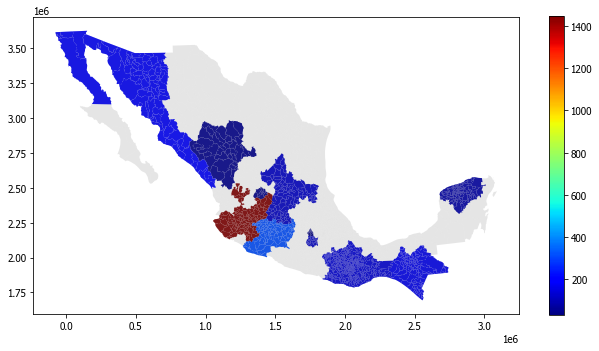

In [39]:
fig, ax = plt.subplots()

barra = mx.plot(column='Installed thermal power , kWth', ax=ax,
                legend=True,cmap='jet',)
base.plot(ax=ax,alpha=0.2,color='grey')
fig.set_size_inches(tamanio)



In [26]:
barra.

AttributeError: 'str' object has no attribute 'patches'

/Users/gbv/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/gbv/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 7
  Warn("Warning: setting k to %d" % k_q, UserWarning)


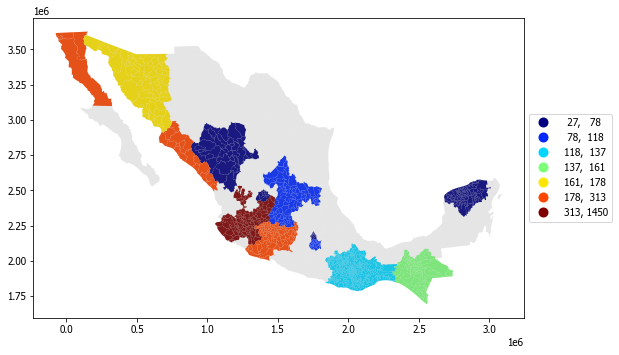

In [20]:
fig, ax = plt.subplots()

barra = mx.plot(column='Installed thermal power , kWth', ax=ax,
                legend=True,cmap='jet',scheme='quantiles', k=10,
                legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),
                         'fmt': "{:.0f}"})
base.plot(ax=ax,alpha=0.2,color='grey')
fig.set_size_inches(tamanio)


In [17]:
# pip install --upgrade mapclassify